In [296]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [297]:
import os, sys
import numpy as np 
# import pandas as pd 
import matplotlib.pyplot as plt
# import geopandas as gpd
import sklearn, sklearn.cross_decomposition
from sklearn.cross_decomposition import CCA
sys.path.append('../src/')
sys.path.append('../content/')
import data_utils as du
import loadpaths
path_dict_pecl = loadpaths.loadpaths()
import analysis_utils as au

Sentinel-2: (4, 128, 128) <class 'xarray.core.dataarray.DataArray'>
AlphaEarth: (64, 128, 128) <class 'xarray.core.dataarray.DataArray'>
Dynamic World: (9, 128, 128) <class 'xarray.core.dataarray.DataArray'>
WorldClimBio: <class 'dict'> dict_keys(['bio01', 'bio02', 'bio03', 'bio04', 'bio05', 'bio06', 'bio07', 'bio08', 'bio09', 'bio10', 'bio11', 'bio12', 'bio13', 'bio14', 'bio15', 'bio16', 'bio17', 'bio18', 'bio19', 'coords', 'name'])
Sentinel-2: 0 nans, 0 infs
AlphaEarth: 0 nans, 0 infs
Dynamic World: 0 nans, 0 infs


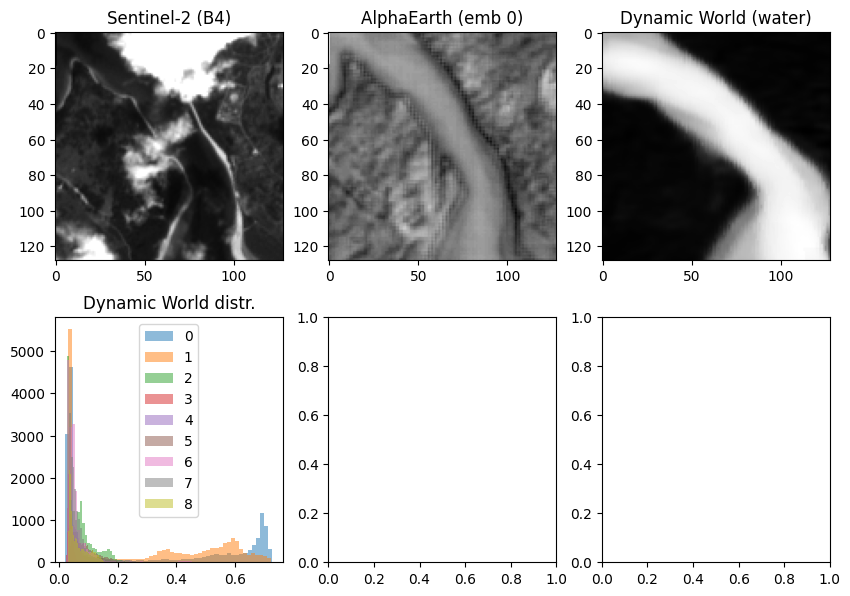

In [298]:
(data_sent, data_alpha, data_dyn, data_worldclim) = du.load_all_modalities_from_name(name='pecl-fig-0', path_folder='../content/sample_data', verbose=1)

## Check for number of nans, infs

data_alpha.values[np.isinf(data_alpha.values)] = 0

for arr, name in zip([data_sent, data_alpha, data_dyn], ['Sentinel-2', 'AlphaEarth', 'Dynamic World']):
    print(f"{name}: {np.sum(np.isnan(arr.values))} nans, {np.sum(np.isinf(arr.values))} infs")
    
fig, ax = plt.subplots(2,3, figsize=(10,7))
ax = ax.flatten()
ax[0].imshow(np.clip(data_sent[0, ...], 0, 3000) / 3000, cmap='gray')
ax[0].set_title('Sentinel-2 (B4)')
ax[1].imshow(data_alpha[0, ...], cmap='gray')
ax[1].set_title('AlphaEarth (emb 0)')
ax[2].imshow(data_dyn[0, ...], cmap='gray')
ax[2].set_title('Dynamic World (water)')

## plot distr DW:
for i_dw in range(data_dyn.shape[0]):
    ax[3].hist(data_dyn[i_dw, ...].values.flatten(), bins=50, alpha=0.5, label=i_dw)
ax[3].set_title('Dynamic World distr.')
ax[3].legend()

(64, 16384) (9, 16384)
[0.58661765 0.5873249  0.5929653  0.5956182  0.5968179  0.60670626
 0.6237366  0.6303861  0.64634985 0.6509705 ]


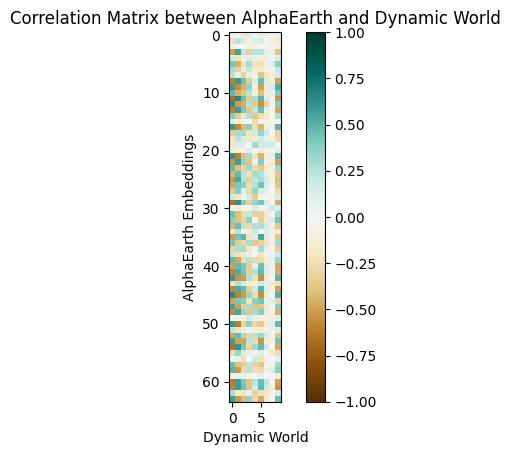

In [299]:
embed_mat = data_alpha.values.reshape(data_alpha.shape[0], -1)
dw_mat = data_dyn.values.reshape(data_dyn.shape[0], -1)
assert embed_mat.shape[1] == dw_mat.shape[1]

corr_mat = au.correlation_two_matrices(embed_mat, dw_mat)
plt.imshow(corr_mat, vmin=-1, vmax=1, cmap='BrBG')
plt.colorbar()
plt.xlabel('Dynamic World')
plt.ylabel('AlphaEarth Embeddings')
plt.title('Correlation Matrix between AlphaEarth and Dynamic World')

print(np.sort(corr_mat.flatten())[-10:])

Corr embd 3 vs dw 1: 0.5486385822296143


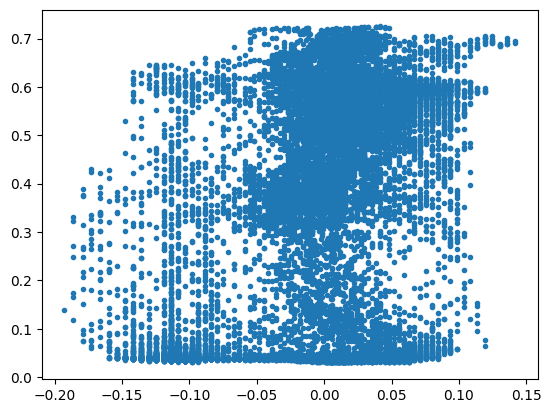

In [300]:
ind_embd = 3
ind_dw = 1
print(f"Corr embd {ind_embd} vs dw {ind_dw}: {corr_mat[ind_embd, ind_dw]}")

plt.plot(embed_mat[ind_embd, :], dw_mat[ind_dw, :], '.')
# print(np.corrcoef(embed_mat[ind_embd, :], dw_mat[ind_dw, :]))

# CCA

In [301]:
cca = CCA(n_components=6)
X_c, Y_c = cca.fit_transform(embed_mat.T, dw_mat.T)
# print(X_c.shape, Y_c.shape)
corrs = [np.corrcoef(X_c[:, i], Y_c[:, i])[0, 1] for i in range(cca.n_components)]
print("Canonical correlations:", np.round(corrs, 3))

Canonical correlations: [0.912 0.792 0.685 0.633 0.596 0.551]


(6, 16384) (6, 16384)


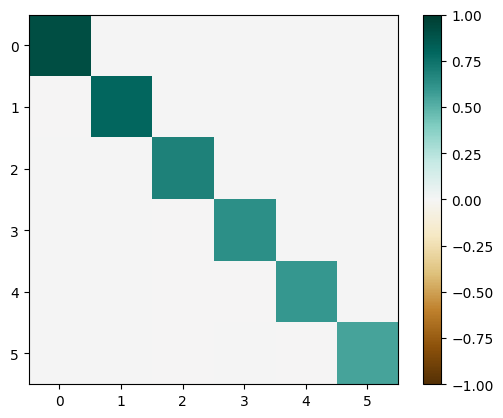

In [302]:

plt.imshow(au.correlation_two_matrices(X_c.T, Y_c.T), vmin=-1, vmax=1, cmap='BrBG')
plt.colorbar()

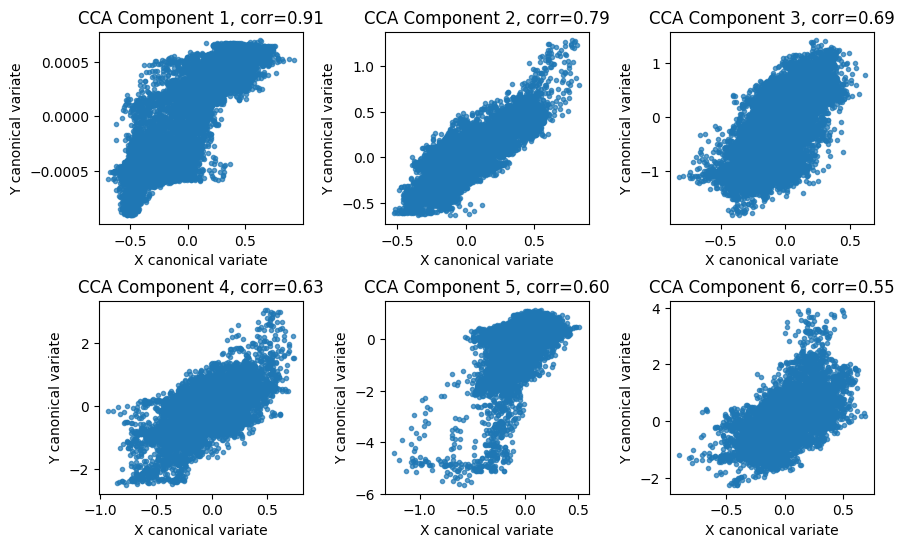

In [303]:
fig, ax = plt.subplots(2, 3, figsize=(10, 6), gridspec_kw={'hspace': 0.4, 'wspace': 0.4})
ax = ax.flatten()
for ii in range(cca.n_components):
    ax[ii].plot(X_c[:, ii], Y_c[:, ii], '.', label=f'Component {ii + 1} (corr={corrs[ii]:.2f})', alpha=0.7)
    ax[ii].set_xlabel('X canonical variate')
    ax[ii].set_ylabel('Y canonical variate')
    ax[ii].set_title(f'CCA Component {ii + 1}, corr={corrs[ii]:.2f}')
# plt.xlabel("X canonical variate")
# plt.ylabel("Y canonical variate")
# plt.legend()
# plt.title("Canonical Correlation Analysis (CCA)")
# plt.show()

x_weights: (64, 6)
Min, max: -0.3628656760139933, 0.4474708491608703
y_weights: (9, 6)
Min, max: -0.7249009000630422, 0.7322184608205521
x_loadings: (64, 6)
Min, max: -2.4112131735290157, 2.955918278577385
y_loadings: (9, 6)
Min, max: -1961.5042809569395, 1930.7394478117365


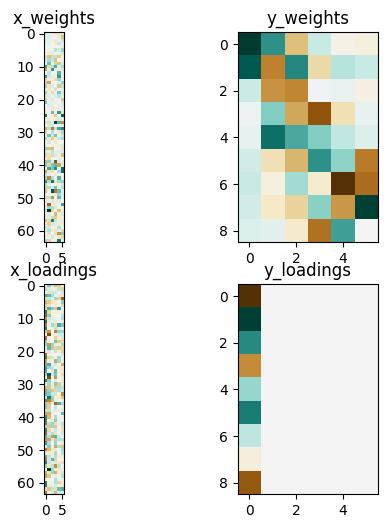

In [304]:
dict_outcome_cca = {
    'x_weights': cca.x_weights_,
    'y_weights': cca.y_weights_,
    'x_loadings': cca.x_loadings_,
    'y_loadings': cca.y_loadings_
}

fig, ax = plt.subplots(2, 2, figsize=(6, 6))
ax = ax.flatten()
for ii, (key, val) in enumerate(dict_outcome_cca.items()):
    print(f"{key}: {val.shape}")
    print(f'Min, max: {np.min(val)}, {np.max(val)}')
    im = ax[ii].imshow(val, cmap='BrBG', vmin=-np.max(np.abs(val)), vmax=np.max(np.abs(val)))
    ax[ii].set_title(key)

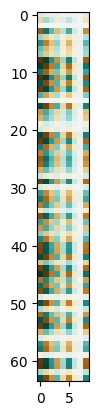

In [305]:
plt.imshow(np.dot(dict_outcome_cca['x_loadings'], dict_outcome_cca['y_loadings'].T), cmap='BrBG')

In [306]:
X = embed_mat.T
Y = dw_mat.T
canonical_corrs = np.array([np.corrcoef(X_c[:, i], Y_c[:, i])[0, 1] for i in range(cca.n_components)])
print("Canonical correlations:", canonical_corrs)

# --- 4. Compute Redundancy Index ---
# Correlations of original variables with canonical variates
corr_X_U = np.corrcoef(X.T, X_c.T)[0:X.shape[1], X.shape[1]:]
corr_Y_V = np.corrcoef(Y.T, Y_c.T)[0:Y.shape[1], Y.shape[1]:]

# Variance explained by each canonical variate in X and Y
var_expl_X = np.mean(corr_X_U**2, axis=0)
var_expl_Y = np.mean(corr_Y_V**2, axis=0)

# Redundancy per component
redundancy_X = canonical_corrs**2 * var_expl_X
redundancy_Y = canonical_corrs**2 * var_expl_Y

print("Variance explained in X per component:", var_expl_X)
print("Variance explained in Y per component:", var_expl_Y)
print("Redundancy (variance explained) in X:", redundancy_X)
print("Redundancy (variance explained) in Y:", redundancy_Y)


Canonical correlations: [0.91230319 0.79209658 0.68513466 0.63252035 0.59596107 0.5510786 ]
Variance explained in X per component: [0.27473728 0.04363567 0.01255246 0.03665172 0.00930009 0.0166199 ]
Variance explained in Y per component: [0.36373821 0.07664161 0.1911924  0.06349088 0.11465745 0.08588596]
Redundancy (variance explained) in X: [0.22866305 0.02737776 0.00589224 0.01466369 0.00330311 0.00504726]
Redundancy (variance explained) in Y: [0.30273826 0.04808625 0.08974753 0.02540156 0.04072284 0.0260825 ]


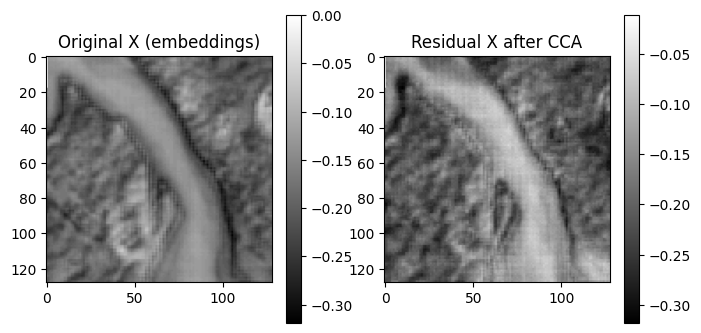

In [307]:
X_hat = X_c @ cca.x_weights_.T
X_residual = X - X_hat

orig_dim = 128 
assert orig_dim ** 2 == X.shape[0]
X_residual_img = X_residual.T.reshape(-1, orig_dim, orig_dim)
X_img = X.T.reshape(-1, orig_dim, orig_dim)


ind_plot = 0

fig, ax = plt.subplots(1, 2, figsize=(8, 4))
ax[0].imshow(X_img[ind_plot, ...], cmap='gray')
ax[0].set_title('Original X (embeddings)')
# colorbar
fig.colorbar(ax[0].imshow(X_img[ind_plot, ...], cmap='gray'), ax=ax[0])
ax[1].imshow(X_residual_img[ind_plot, ...], cmap='gray')
ax[1].set_title('Residual X after CCA')
# colorbar
fig.colorbar(ax[1].imshow(X_residual_img[ind_plot, ...], cmap='gray'), ax=ax[1])
plt.show()


(64, 16384) (9, 16384)
(64, 16384) (9, 16384)


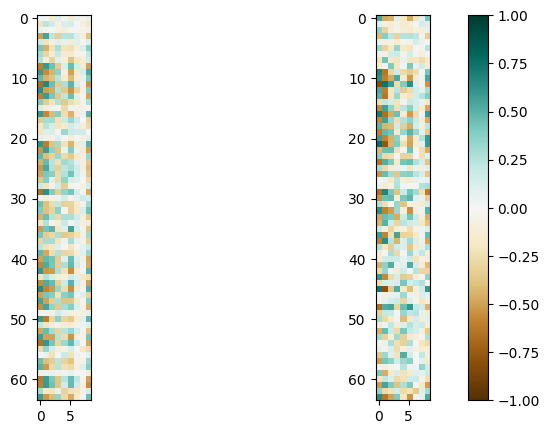

In [308]:
embed_mat = data_alpha.values.reshape(data_alpha.shape[0], -1)
dw_mat = data_dyn.values.reshape(data_dyn.shape[0], -1)
assert embed_mat.shape[1] == dw_mat.shape[1]

corr_mat = au.correlation_two_matrices(embed_mat, dw_mat)

fig, ax = plt.subplots(1,2, figsize=(10,5))
im = ax[0].imshow(corr_mat, vmin=-1, vmax=1, cmap='BrBG')
# fig.colorbar(im, ax=ax)

im = ax[1].imshow(au.correlation_two_matrices(X_residual.T, dw_mat), vmin=-1, vmax=1, cmap='BrBG')
fig.colorbar(im, ax=ax)

# CCA Multi

In [313]:

# Then collect from all patches the alpha and dyn data
patches = 10
hypotheses = []
features = []
sentinel = []
for p in range(patches):
    (data_sent, data_alpha, data_dyn, data_worldclim) = du.load_all_modalities_from_name(name=f'pecl-fig-{p}', path_folder='../content/sample_data', verbose=1)
    # Land coverage serves as hypotheses
    hypotheses.append(data_dyn.data)
    # This can definitely be cleaner but I use nan for undefined values
    f_dat = data_alpha.data
    f_dat[~np.isfinite(f_dat)] = 0
    # f_dat[np.logical_and(f_dat < 0.05, f_dat > -0.05)] = 0  # Thresholding to remove noise

    # cca = CCA(n_components=2)
    # X = f_dat.reshape(64, -1).T
    # Y = data_dyn.data.reshape(data_dyn.shape[0], -1).T
    # X_c, Y_c = cca.fit_transform(X, Y)
    # X_hat = X_c @ cca.x_weights_.T
    # X_residual = X - X_hat
    # f_dat_residual = X_residual.T.reshape(f_dat.shape)
    # print(X_residual.shape, f_dat.shape, X.shape, f_dat_residual.shape)
    # assert False
    features.append(f_dat)
    sentinel.append(data_sent.data)

Sentinel-2: (4, 128, 128) <class 'xarray.core.dataarray.DataArray'>
AlphaEarth: (64, 128, 128) <class 'xarray.core.dataarray.DataArray'>
Dynamic World: (9, 128, 128) <class 'xarray.core.dataarray.DataArray'>
WorldClimBio: <class 'dict'> dict_keys(['bio01', 'bio02', 'bio03', 'bio04', 'bio05', 'bio06', 'bio07', 'bio08', 'bio09', 'bio10', 'bio11', 'bio12', 'bio13', 'bio14', 'bio15', 'bio16', 'bio17', 'bio18', 'bio19', 'coords', 'name'])
Sentinel-2: (4, 128, 128) <class 'xarray.core.dataarray.DataArray'>
AlphaEarth: (64, 128, 128) <class 'xarray.core.dataarray.DataArray'>
Dynamic World: (9, 128, 128) <class 'xarray.core.dataarray.DataArray'>
WorldClimBio: <class 'dict'> dict_keys(['bio01', 'bio02', 'bio03', 'bio04', 'bio05', 'bio06', 'bio07', 'bio08', 'bio09', 'bio10', 'bio11', 'bio12', 'bio13', 'bio14', 'bio15', 'bio16', 'bio17', 'bio18', 'bio19', 'coords', 'name'])
Sentinel-2: (4, 128, 128) <class 'xarray.core.dataarray.DataArray'>
AlphaEarth: (64, 128, 128) <class 'xarray.core.dataarray

In [ ]:
data_dyn.data.reshape(data_dyn.shape[0], -1).shape

(9, 16384)

In [327]:
np.stack(features).shape

def ravel_features(features):
    assert len(features.shape) == 4
    n_patches, n_features, nx, ny = features.shape
    return np.swapaxes(features, 0, 1).reshape((n_features, -1))

def unravel_features(raveled, n_patches, nx, ny):
    n_features = raveled.shape[0]
    return np.swapaxes(raveled.reshape((n_features, n_patches, nx, ny)), 0, 1)

In [368]:
# X = np.swapaxes(np.stack(features), 0, 1).reshape(64, -1)
# Y = np.swapaxes(np.stack(hypotheses), 0, 1).reshape(9, -1)
X = ravel_features(np.stack(features))
Y = ravel_features(np.stack(hypotheses))
assert X.shape[1] == Y.shape[1], (X.shape, Y.shape)

cca = CCA(n_components=6)
X_c, Y_c = cca.fit_transform(X.T, Y.T)
# print(X_c.shape, Y_c.shape)
corrs = [np.corrcoef(X_c[:, i], Y_c[:, i])[0, 1] for i in range(cca.n_components)]
print("Canonical correlations:", np.round(corrs, 3))


Canonical correlations: [0.898 0.869 0.816 0.735 0.591 0.562]


In [337]:

X_hat = X_c @ cca.x_weights_.T
X_residual = X - X_hat.T
X_residual_img = unravel_features(X_residual, n_patches=10, nx=128, ny=128)
# X_residual_img = X_residual.T.reshape((64, 128, 128, 10))
# X_residual_img = np.swapaxes(X_residual_img, 0, 3)
X_residual_img.shape
X_hat_img = unravel_features(X_hat.T, n_patches=10, nx=128, ny=128)

In [373]:
tmp_y = np.dot(cca.y_weights_.T, hypotheses[0].reshape(9, -1)).reshape(cca.n_components,128, 128) 

In [369]:
np.dot(cca.x_weights_.T, features[0].reshape(64, -1)).shape

(6, 16384)

In [370]:
cca.x_weights_.T.shape
# X_c.shape

# features[0].shape

tmp = np.dot(cca.x_weights_.T, features[0].reshape(64, -1)).reshape(cca.n_components, 128, 128) 

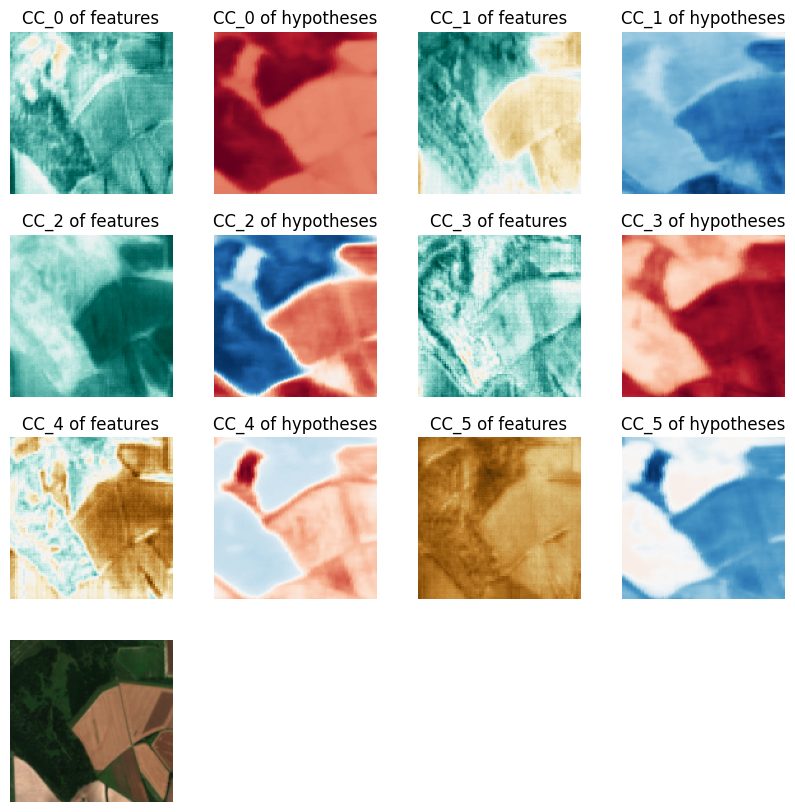

In [416]:
# ind_cc = 1
ind_patch += 1

fig, ax = plt.subplots(cca.n_components // 2 + 1, 4, figsize=(10, 10), 
                       gridspec_kw={'hspace': 0.25, 'wspace': 0.25})
ax = ax.ravel()
ii = 0
for ind_cc in range(cca.n_components):
    tmp = np.dot(cca.x_weights_.T, features[ind_patch].reshape(64, -1)).reshape(cca.n_components, 128, 128) 
    feat_lim = np.max(np.abs(tmp[ind_cc]))
    tmp_y = np.dot(cca.y_weights_.T, hypotheses[ind_patch].reshape(9, -1)).reshape(cca.n_components,128, 128) 
    hyp_lim = np.max(np.abs(tmp_y[ind_cc]))
    curr_ax_feat = ax[ii]
    curr_ax_hyp = ax[ii + 1]
    curr_ax_feat.imshow(tmp[ind_cc], cmap='BrBG_r', vmin=-feat_lim, vmax=feat_lim)
    # ax[0].imshow(X_hat_img[0, 1, :, :], cmap='gray')
    # ax[1].imshow(features[0][1, ...], cmap='gray')
    curr_ax_hyp.imshow(tmp_y[ind_cc], cmap='RdBu_r', vmin=-hyp_lim, vmax=hyp_lim)
    curr_ax_feat.set_title(f'CC_{ind_cc} of features')
    curr_ax_hyp.set_title(f'CC_{ind_cc} of hypotheses')

    ii += 2

ax[ii].imshow(np.clip(np.swapaxes(np.swapaxes(sentinel[ind_patch][:3], 0, 2), 0, 1), 0, 3000) / 3000)

for a in ax:
    a.axis('off')

In [389]:
tmp.max()

0.19857486696462012

In [ ]:


# --- 4. Compute Redundancy Index ---
# Correlations of original variables with canonical variates
corr_X_U = np.corrcoef(X, X_c.T)[0:X.shape[0], X.shape[0]:]
corr_Y_V = np.corrcoef(Y, Y_c.T)[0:Y.shape[0], Y.shape[0]:]

# Variance explained by each canonical variate in X and Y
var_expl_X = np.mean(corr_X_U**2, axis=0)
var_expl_Y = np.mean(corr_Y_V**2, axis=0)

# Redundancy per component
redundancy_X = canonical_corrs**2 * var_expl_X
redundancy_Y = canonical_corrs**2 * var_expl_Y

print("Variance explained in X per component:", var_expl_X)
print("Variance explained in Y per component:", var_expl_Y)
print("Redundancy (variance explained) in X:", redundancy_X)
print("Redundancy (variance explained) in Y:", redundancy_Y)

Variance explained in X per component: [0.17650719 0.15044646 0.0594682  0.07466599 0.03555005 0.02552099]
Variance explained in Y per component: [0.22517861 0.21201928 0.12312817 0.14344512 0.11212001 0.08787048]
Redundancy (variance explained) in X: [0.14690642 0.09439267 0.02791494 0.02987252 0.0126263  0.00775041]
Redundancy (variance explained) in Y: [0.18741551 0.1330245  0.05779753 0.05738981 0.03982162 0.02668518]
